In [1]:
import cPickle
import gzip

from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from breze.learn.utils import tile_raster_images

import climin.stops


import climin.initialize

from breze.learn import sgvb
from matplotlib import pyplot as plt
from matplotlib import cm

import numpy as np

#import fasttsne

#from IPython.html import widgets
%matplotlib inline 

import theano
import theano.tensor as T
theano.config.compute_test_value = 'ignore'#'raise'

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '569' (I am process '827')
ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.6.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.6.0: cannot open shared object file: No such file or directory


In [2]:
datafile = '../mnist.pkl.gz'
# Load data.                                                                                                   

with gzip.open(datafile,'rb') as f:                                                                        
    train_set, val_set, test_set = cPickle.load(f)                                                       

X, Z = train_set                                                                                               
VX, VZ = val_set
TX, TZ = test_set

Z = one_hot(Z, 10)
VZ = one_hot(VZ, 10)
TZ = one_hot(TZ, 10)

image_dims = 28, 28

X, Z, VX, VZ, TX, TZ = [cast_array_to_local_type(i) for i in (X, Z, VX,VZ, TX, TZ)]

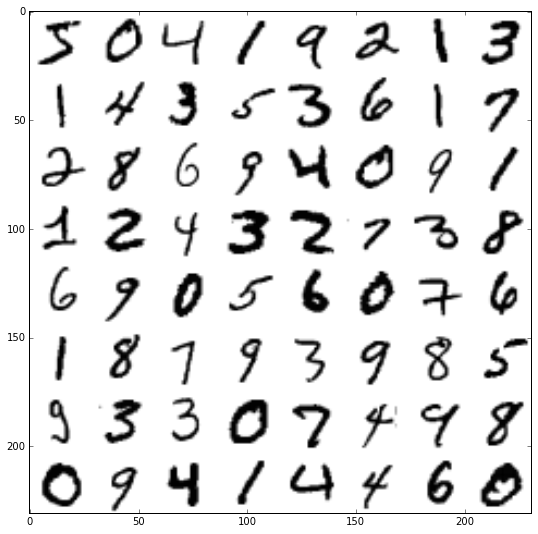

In [3]:
fig, ax = plt.subplots(figsize=(9, 9))

img = tile_raster_images(X[:64], image_dims, (8, 8), (1, 1))
ax.imshow(img, cmap=cm.binary)

In [4]:
from breze.arch.construct.layer.distributions import NormalGauss, NormalizingFlow
from breze.arch.construct.neural import Mlp

class PlanarNormalizingFlow(NormalizingFlow):

    def __init__(self, inpt, n_inpt, n_layer, n_output,
                 declare=None, name=None, rng=None):
        self.inpt = inpt
        self.n_inpt = n_inpt
        self.n_output = n_output
        
        self.stt = T.zeros((inpt.shape[0], n_output * 2))
    
        self.mlp = Mlp( inpt,
            n_inpt,
            [128] * 2, self.n_output * 2 + n_output * 2 * n_layer + n_layer,
            ['sigmoid'] * 2, 'identity',
            declare=declare)

        mean_0 = self.mlp.output[:, :self.n_output]
        var_0 = T.exp(self.mlp.output[:, self.n_output:self.n_output * 2])
        
        rng = T.shared_randomstreams.RandomStreams()
        self.z_0 = mean_0 + rng.normal(size=(inpt.shape[0], n_output)) * T.sqrt(var_0 + 1e-5)
        
        f = lambda x: T.tanh(x)
        df = lambda x: 1.0 / T.cosh(x)
        z = self.z_0
        logdet = 0.0
        for i in range(n_layer):
            w = self.mlp.output[:, self.n_output * 2 + (n_output * 2 + 1) * i:self.n_output * 3 + (n_output * 2 + 1) * i]
            u = self.mlp.output[:, self.n_output * 3 + (n_output * 2 + 1) * i:self.n_output * 4 + (n_output * 2 + 1) * i]
            b = self.mlp.output[:, self.n_output * 4 + (n_output * 2 + 1) * i:self.n_output * 4 + 1 + (n_output * 2 + 1) * i]
            
            m = lambda x: - 1.0 + T.log(1.0 + T.exp(x))
            u = u + (m((w * u).sum(axis=1)) - (w * u).sum(axis=1)).dimshuffle(0, 'x') * w / (w**2).sum(1).dimshuffle(0, 'x')
            
            logdet -= T.log(abs(1.0 + (u * df( (z * w).sum(1) + b.ravel()).dimshuffle(0, 'x') * w).sum(1) ))
            z = z + u * f((z * w).sum(1) + b.ravel()).dimshuffle(0, 'x')
            
        self.z = z
        self.logdet = logdet.dimshuffle(0, 'x') / self.n_output
        
        super(PlanarNormalizingFlow, self).__init__(
            mean_0,
            var_0,
            self.logdet)
        
    def sample(self, epsilon=None):
        return self.z

class PlanarNormalizingFlowLatentVAEMixin(object):

    def make_prior(self, sample):
        return NormalGauss(sample.shape)

    def make_recog(self, inpt):
        return PlanarNormalizingFlow(
            inpt, self.n_inpt,
            3,
            self.n_latent,
            declare=self.parameters.declare)

In [5]:
batch_size = 200
#optimizer = 'rmsprop', {'step_rate': 1e-4, 'momentum': 0.95, 'decay': .95, 'offset': 1e-6}
#optimizer = 'adam', {'step_rate': .5, 'momentum': 0.9, 'decay': .95, 'offset': 1e-6}
optimizer = 'adam'

reload(sgvb)

class MyVAE(sgvb.VariationalAutoEncoder,
            PlanarNormalizingFlowLatentVAEMixin, 
            sgvb.MlpBernoulliVisibleVAEMixin, 
            ):
    pass
kwargs = {}

# This is the number of random variables NOT the size of 
# the sufficient statistics for the random variables.
n_latents = 64
n_hidden = 512

m = MyVAE(X.shape[1], [n_hidden], n_latents, [n_hidden], ['rectifier'] * 1, ['rectifier'] * 1,
          optimizer=optimizer, batch_size=batch_size,
          **kwargs)

climin.initialize.randomize_normal(m.parameters.data, 0, 1e-2)

m.estimate_nll(X[:10])

In [38]:
max_passes = 250
max_iter = max_passes * X.shape[0] / batch_size
n_report = X.shape[0] / batch_size

stop = climin.stops.AfterNIterations(max_iter)
pause = climin.stops.ModuloNIterations(n_report)

for i, info in enumerate(m.powerfit((X,), (VX[:1],), stop, pause)):
    print i, info['loss'], info['val_loss']


0 116.631 98.2461
1 116.663 95.8725
2 116.413 101.854
3 116.373 91.8361
4 116.348 112.743
5 116.107 101.869
6 116.001 98.4539
7 115.889 108.261
8 116.101 104.667
9 115.808 106.791
10 115.687 111.264
11 115.501 103.077
12 115.212 100.134
13 115.122 97.052
14 115.372 89.7031
15 114.851 106.553
16 114.772 110.761
17 114.609 102.881
18 114.736 104.602
19 114.314 91.9581
20 114.543 96.3012
21 113.982 103.809
22 114.209 105.546
23 113.654 94.2647
24 113.731 105.595
25 113.482 112.129
26 113.247 97.3201
27 113.332 100.915
28 113.212 107.714
29 112.859 92.808
30 112.759 92.9056
31 112.883 106.407
32 112.694 115.393
33 112.578 100.254
34 112.433 108.542
35 112.432 96.557
36 112.2 104.162
37 112.155 104.746
38 112.184 97.5125
39 111.89 109.261
40 111.859 117.505
41 112.023 111.194
42 111.636 96.6399
43 112.014 105.53
44 111.529 111.615
45 111.473 114.925
46 111.601 117.745
47 111.48 102.002
48 111.195 105.014
49 111.455 111.218
50 111.243 99.7692
51 111.399 106.208
52 111.087 116.027
53 111.153 

m.parameters.data[...] = info['best_pars']

In [39]:
f_sample = m.function([m.recog_sample], m.vae.gen.sample())
f_recons = m.function(['inpt'], m.vae.gen.sample())

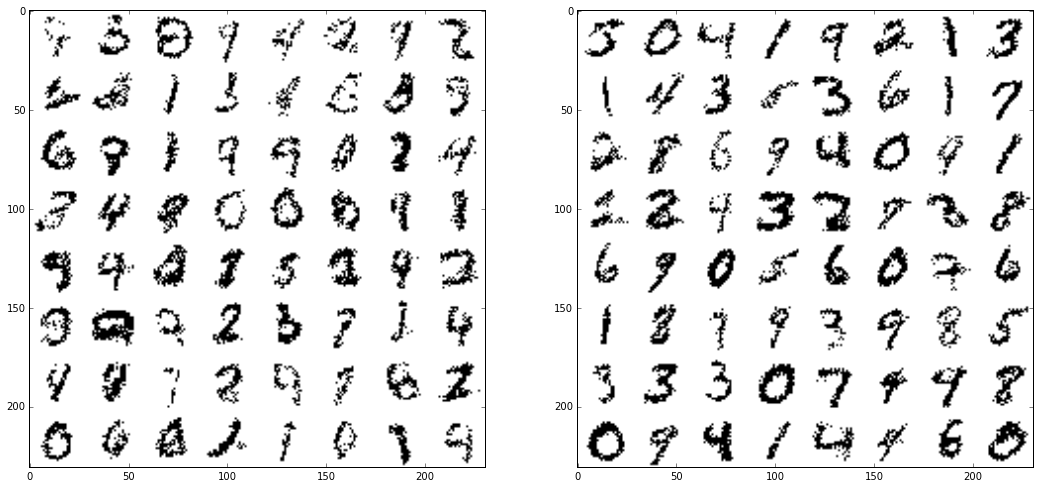

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

S = f_sample(np.random.randn(64, m.n_latent).astype('float32'))[:, :784].astype('float32')
img = tile_raster_images(S, image_dims, (8, 8), (1, 1))
axs[0].imshow(img, cmap=cm.binary)

R = f_recons(X[:64])[:, :784].astype('float32')
img = tile_raster_images(R, image_dims, (8, 8), (1, 1))

axs[1].imshow(img, cmap=cm.binary)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))
img = tile_raster_images(m.parameters[m.vae.recog.mlp.layers[0].weights].T, image_dims, (10, 10), (1, 1))
axs[0].imshow(img, cmap=cm.binary)

img = tile_raster_images(m.parameters[m.vae.gen.mlp.layers[-1].weights], image_dims, (10, 10), (1, 1))
axs[1].imshow(img, cmap=cm.binary)

In [41]:
f_L = m.function([m.vae.inpt], m.vae.recog.sample(), on_unused_input='ignore')
f_L_mean0 = m.function([m.vae.inpt], m.vae.recog.mean_0, on_unused_input='ignore')
f_L_var0 = m.function([m.vae.inpt], m.vae.recog.var_0, on_unused_input='ignore')

In [42]:
L = f_L(X)
L_mean0 = f_L_mean0(X)
L_var0 = f_L_var0(X)
L0 = L_mean0 + np.random.randn(*L_mean0.shape) * np.sqrt(L_var0)

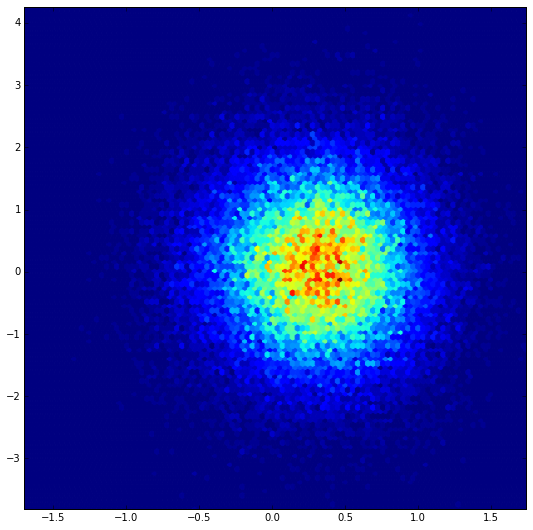

In [43]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.hexbin(L0[:, 0], L0[:, 1])

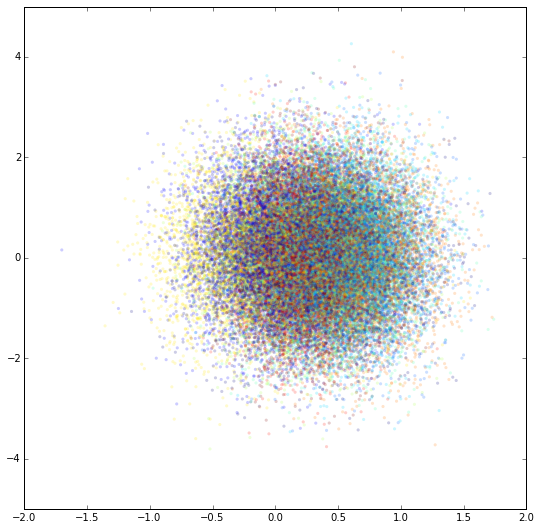

In [44]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(L0[:, 0], L0[:, 1], c=Z[:].argmax(1), lw=0, s=10, alpha=.2)

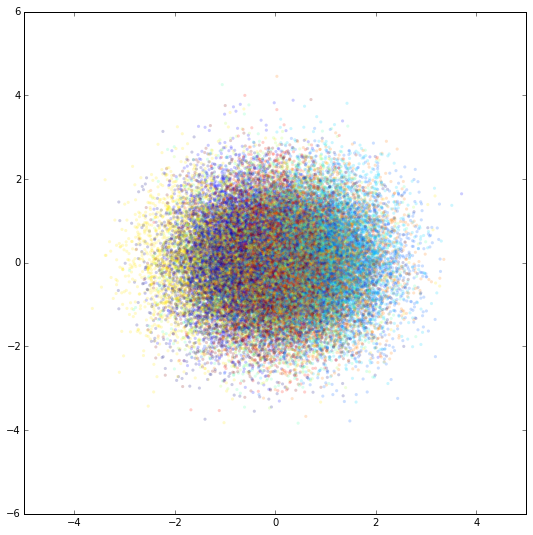

In [45]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(L[:, 0], L[:, 1], c=Z[:].argmax(1), lw=0, s=10, alpha=.2)